# IPython and cross language integration

See more at https://carreau.github.io/posts/23-Cross-Language-Integration.html

In [ ]:
ls

In [ ]:
pwd

In [ ]:
files = !ls *.ipynb
files

We also let you expand Python variable into shell commands:

In [ ]:
who = 'Paris'

In [ ]:
!echo "Hello "{who}

## Multi languages

In [ ]:
def fib(n):
    """
    A simple definition of fibonacci manually unrolled
    """
    if n<2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

In [ ]:
[fib(i) for i in range(1,10)]

Store the value from 1 to 30 in `Y`, and graph it.

In [ ]:
%matplotlib inline
import numpy as np
X = np.arange(1,30)
Y = np.array([fib(x) for x in X])

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, Y)
ax.set_xlabel('n')
ax.set_ylabel('fib(n)')
ax.set_title('The Fibonacci sequence grows fast !')

In [ ]:
#!a2km add-env 'python 3' DYLD_FALLBACK_LIBRARY_PATH=$HOME/anaconda/pkgs/icu-54.1-0/lib:/Users/bussonniermatthias/anaconda/pkgs/zlib-1.2.8-3/lib 

In [ ]:
%load_ext rpy2.ipython

The Following will "Send" the X and Y array to R.

In [ ]:
%Rpush Y X

And now let's try to fit a linear model ($ln(Y) = A.X + B$) using R. I'm not a R user myself, so don't take this as idiomatic R.

In [ ]:
%%R
my_summary = summary(lm(log(Y)~X))
val <- my_summary$coefficients

plot(X, log(Y))
abline(my_summary)

In [ ]:
%%R
my_summary

In [ ]:
%%R
val

Or even the following that _looks_ more like python

In [ ]:
%R val

We can even get the variable back from R as Python objects:

In [ ]:
coefs = %Rget val
y0,k = coefs.T[0]
y0,k

That's all from the R part. I hope this shows you some of the power of IPython, both in notebook and command line. 

# CFFI

## Mix and Match : C

In [ ]:
import cffi_magic

In [ ]:
%%cffi int cfib(int);

int cfib(int n)
{
    int res=0;
    if (n <= 1){
        res = 1;
    } else {
        res = cfib(n-1)+cfib(n-2);
    }
    return res;
}

The first line take the "header" of the function we declare, and the rest of the cell takes the body of this function. The `cfib` function will automatically be made available to you in the main python namespace.

In [ ]:
cfib(5) # should be 5 (fixed point)

In [ ]:
%timeit cfib(10)

In [ ]:
%timeit fib(10)

Not so bad considering the C implementation is recursive, and the Python version is manually hand-rolled. 

## Mix and Match : rust

In [ ]:
%%rust int rfib(int);

#[no_mangle]
pub extern fn rfib(n: i32) -> i32 {
    match n {
        0 => 1,
        1 => 1,
        2 => 1,
        _ => rfib(n-1)+rfib(n-2)
    }
}

In [ ]:
[rfib(x) for x in range(1,10)]

In [ ]:
%load_ext fortranmagic

In [ ]:
%%fortran
RECURSIVE SUBROUTINE ffib(n, fibo)  
    IMPLICIT NONE
    INTEGER, INTENT(IN) :: n
    INTEGER, INTENT(OUT) :: fibo
    INTEGER :: tmp
    IF (n <= 2) THEN 
        fibo = 1
    ELSE
        CALL ffib(n-1,fibo)
        CALL ffib(n-2,tmp)
        fibo = fibo + tmp
    END IF
END SUBROUTINE ffib

In [ ]:
[ffib(x) for x in range(1,10)]

No surprise here, you are well aware of what we are doing.

## Cython

IPython used to ship with the Cython magic that is now part of [Cython](http://cython.org/) itself.
Cython is a superset of Python that compiles to C and importable from Python. You should be a ble to take your python code as is, type annotate it, and get c-like speed.
The same principle applies:

In [ ]:
import cython

In [ ]:
%load_ext cython

In [ ]:
%%cython

def cyfib(int n): # note the `int` here
    """
    A simple definition of fibonacci manually unrolled
    """
    cdef int x,y # and the `cdef int x,y` here
    if n < 2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

In [ ]:
[cyfib(x) for x in range(1,10)]

###  benchmark

In [ ]:
%timeit -n100 -r3 fib(5)

In [ ]:
%timeit -n100 -r3 cfib(5)

In [ ]:
%timeit -n100 -r3 ffib(5)

In [ ]:
%timeit -n100 -r3 cyfib(5)

The benchmark result can be astonishing, but keep in mind that the Python and Cython version use manually unrolled loop. Main point being that we reached our goal and used Fortran, Cython, C (and Rust) in the middle of our Python program.

[let's skip the Rust fib version, it tends to segfault, and it would be sad to segfault now :-) ]

In [ ]:
# %timeit rfib(10)

### The Cake is not a lie!

So can we do a layer cake? Can we call rust from Python from Fortran from Cython? Or Cython from C from Fortran? Or Fortron from Cytran from Cust?

In [ ]:
import itertools
lookup = {'c':cfib,
       #'rust': rfib, # as before Rust may segfault, but I dont' know why ...
       'python': fib,
       'fortran': ffib,
       'cython': cyfib
         }

print("Pray the demo-gods it wont segfault even without rust...")

In [ ]:
for function in lookup.values():
    assert function(5) == 5, "Make sure all is correct or will use 100% CPU for a looong time."

In [ ]:
import time
for order in itertools.permutations(lookup):
    time.sleep(0.3)
    t = 5
    for f in order:
        t = lookup[f](t)
    
    print(' -> '.join(order), ':', t)

In [ ]:
print('It worked ! I can run all the permutations !')

# For more, see sharing live objects w/ Julia.

In [40]:
%matplotlib inline

In [ ]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...

In [53]:
julia_version = %julia VERSION
julia_version # you can see this is a wrapper

<PyCall.jlwrap 0.5.0>

In [55]:
%julia @pyimport matplotlib.pyplot as plt
%julia @pyimport numpy as np

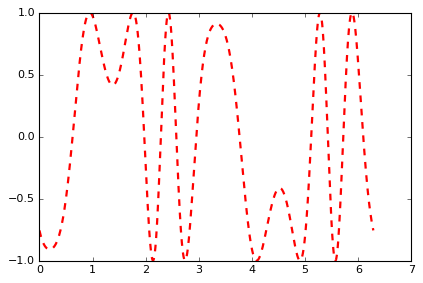

In [56]:
%%julia
                                        # Note how we mix numpy and julia:
t = linspace(0, 2*pi,1000);             # use the julia `linspace` and `pi`
s = sin(3*t + 4*np.cos(2*t));           # use the numpy cosine and julia sine
fig = plt.gcf()                         # **** WATCH THIS VARIABLE ****
plt.plot(t, s, color="red", linewidth=2.0, linestyle="--", label="sin(3t+4.cos(2t))")

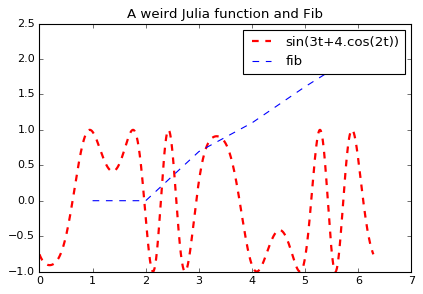

In [57]:
import numpy as np
fig = %julia fig
fig.axes[0].plot(X[:6], np.log(Y[:6]), '--', label='fib')
fig.axes[0].set_title('A weird Julia function and Fib')
fig.axes[0].legend()

fig

In [58]:
from __future__ import print_function


# julia fib function
jlfib = %julia _fib(n, pyfib) = n <= 2 ? 1 : pyfib(n-1, _fib) + pyfib(n-2, _fib)


def pyfib(n, _fib):
    """
    Python fib function
    """
    print('(P', end='')
    if n <= 2:
         r = 1
    else:
        print('(J', end='')
        # here we tell julia (_fib) to recurse using Python
        r =  _fib(n-1, pyfib) + _fib(n-2, pyfib)
        print(')',end='')
    print(')',end='')
    return r

In [59]:
fibonacci = lambda x: pyfib(x, jlfib)
fibonacci(10)

(P(J(P(J(P(J(P(J(P)(P)))(P(J))(P(J))(P)))(P(J(P(J))(P)(P)(P)))(P(J(P(J))(P)(P)(P)))(P(J(P)(P)))))(P(J(P(J(P(J))(P)(P)(P)))(P(J(P)(P)))(P(J(P)(P)))(P(J))))(P(J(P(J(P(J))(P)(P)(P)))(P(J(P)(P)))(P(J(P)(P)))(P(J))))(P(J(P(J(P)(P)))(P(J))(P(J))(P)))))

55